<a href="https://colab.research.google.com/github/esamar/ComponentsJS/blob/main/vision_comp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Dependencias utilizadas##

Para el modelo de procesamiendo de imagenes para obtener informacion de la ficha de registro de discapacidades, si requieren las siguientes librerias

1. Numpy
2. OpenCV
3. MatPlotLib
4. Parches de google Colab

In [7]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

##Ruta de trabajo##

In [6]:
dir = "/content/drive/MyDrive/img_rnee/"

##Filtro por forma de la imagen a tratar##

Previo a iniciar el procesamiento de la imagen, se verifica por medio de su forma si es apto para extraer zonas de interes o si por sus dimensiones no aportará contenido de importacia

In [4]:
def loadImg( img_name ):
  img = cv2.imread(dir + img_name )
  #Validamos si el tipo de datos recuperado del archivo es array o vacío
  print(type(img))
  if ( isinstance(img, (np.ndarray, np.generic)) ):
    height, width, channels = img.shape
    print("img=>'" + img_name + "': " ,height, width, channels)
  else:
    print("img=>'" + img_name + "': Imagen no válida")


In [8]:
loadImg('i_0.jpg')
loadImg('i_9.jpg')
loadImg('i_10.jpg')
loadImg('i_18.jpg')
loadImg('i_29.jpeg')
loadImg('i_121.jpeg')

<class 'NoneType'>
img=>'i_0.jpg': Imagen no válida
<class 'numpy.ndarray'>
img=>'i_9.jpg':  67 240 3
<class 'numpy.ndarray'>
img=>'i_10.jpg':  167 137 3
<class 'numpy.ndarray'>
img=>'i_18.jpg':  1280 896 3
<class 'numpy.ndarray'>
img=>'i_29.jpeg':  780 1040 3
<class 'numpy.ndarray'>
img=>'i_121.jpeg':  1064 1505 3


##Histograma de imagen##
Para poder verificar si la imagen tiene contenido relevante y si vale la pena su procesamiento, se verifica previamente si hay frecuencias de colores, si este presenta fecuencia dispersa, se puede considerar una imagen con contenido relevante

In [11]:
def histoImg( img_name ):
  img = cv2.imread(dir + img_name, 0)
  hist, bins = np.histogram(img.ravel(), 256, [0, 256])
  print("hist", hist)
  #print("bins", bins)

In [12]:
histoImg('i_9.jpg')

hist [   6    3    3    1    0    1    0    0    1    0    0    0    0    0
    0    0    2    2    0    1    0    4    4    1    1    2    4    6
    3    5    3    4   10    9   11   18   20   25   26   34   33   31
   31   32   37   67   45   38   49   82  106  138  175  207  297  222
  257  207  378  411  470  550 1022 1518  253  140  132  146   87  103
   90   75  113  207  225  216  223  174  122  101   87   84   52   53
   42   28   37   42   37   52   36   29   31   34   41   31   39   38
   40   35   37   39   32   40   25   40   50   37   40   31   44   37
   41   38   38   51   43   20   18   34   23   20   21   34   27   24
   14   20   28   18   33   15   23   30   25   30   31   24   26   24
   26   21   16   25   28   16   20   23   21   20   32   28   29   28
   22   37   24   36   42   26   34   42   46   50   49   47   41   38
   31   27   27   20   16   12   10   12    9   10    9    8   11    6
    8    9   11   12   18   16   17   24   19   24   12   11   14   11
 

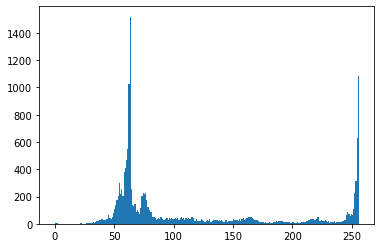

In [13]:
img = cv2.imread(dir+'i_9.jpg',0)
plt.hist(img.ravel(),256,[0,256]); plt.show()

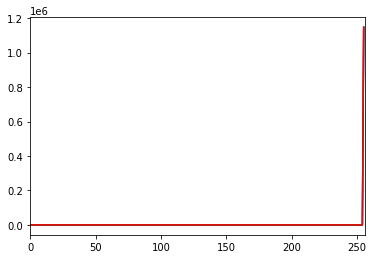

In [14]:
img = cv2.imread(dir+'i_18.jpg')
color = ('b', 'g', 'r')
for i, col in enumerate(color):
    histr = cv2.calcHist([img], [i], None, [256], [0, 256])
    plt.plot(histr, color=col)
    plt.xlim([0, 256])
plt.show()

##Preparar la imagen##
En esta seccion se prepara la imagen para su procesamiento. Se determinó mediante prueba que el alto base a considerar en el tratamiento de todas las imagenes de entrada es igual a 1000 pixeles y el ancho relativo a la proporción. Este valor puede ser modificado segun los requerimientos de los procesos posteriores.

Original:  (1040, 780, 3)
Resized:  (1000, 750, 3)


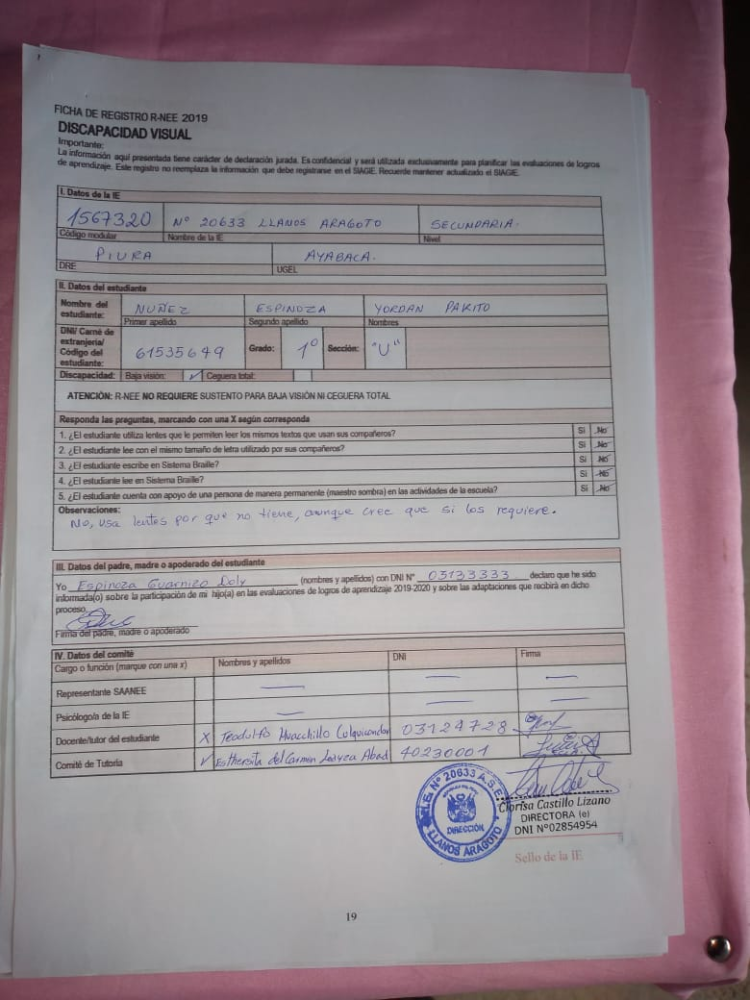

In [37]:
def resize_base_img(img_to_process):

  print('Original: ',img_to_process.shape)

  h , w , _ = img_to_process.shape

  h_resizeBase = 1000

  w_resizeBase = int( ( w * ( (h_resizeBase*100)/h ) ) / 100 )

  resized = cv2.resize(img_to_process, (w_resizeBase,h_resizeBase), interpolation = cv2.INTER_AREA)

  print('Resized: ',resized.shape)

  cv2_imshow(resized)

  return resized

image = resize_base_img( cv2.imread(dir + 'i_ok.jpg') )
#image = resize_base_img( cv2.imread(dir + 'i_perspective.jpeg') )

#resize_base_img()

##Procesamiento de la imagen##

Se inicia el procesamiento primero convirtiendo la imagen a escala de grises. Luego se probó diferentes técnicas para poder encontrar los relieves y bordes. En el código se puede ver las líneas comentadas la técnica de umbralización que no tuvo buen resultado.

Se utiliza entonces la técnica CANNY modulado a umbrales 100 y 200 

Lo siguiente es dilatar el resultante para que los bordes detectados se cierren. Se utiliza 5 iteraciones 

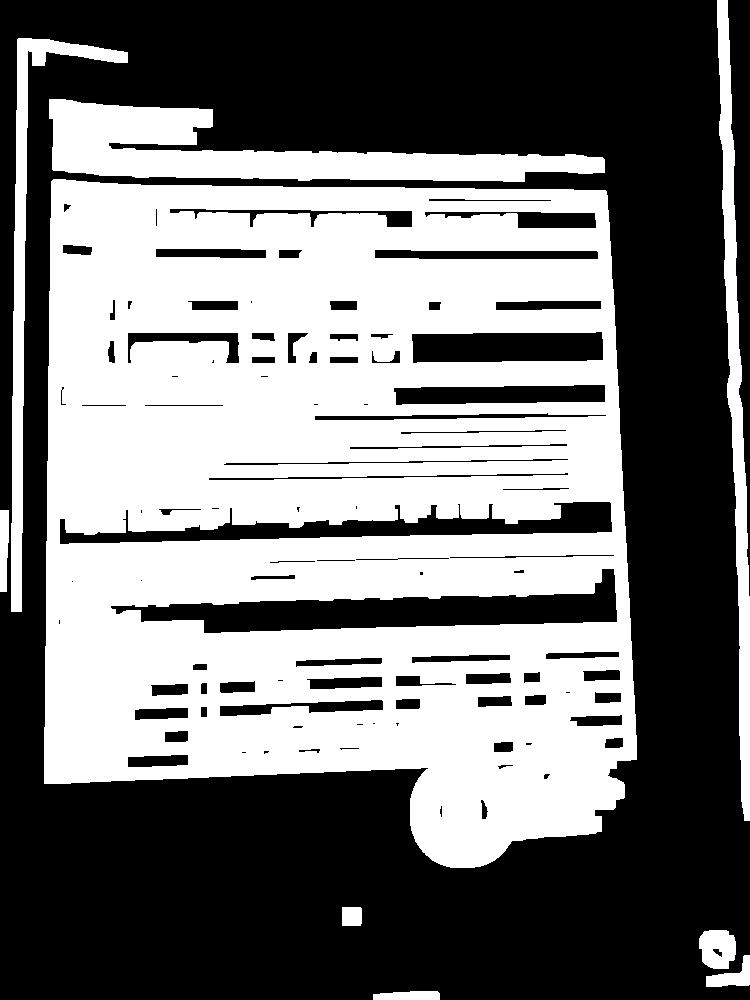

In [74]:

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
canny = cv2.Canny(gray, 100,200)
canny = cv2.dilate(canny, None, iterations = 5 )
#canny = cv2.erode(canny, None, iterations = 1)
# _, th = cv2.threshold(gray, 10,255,cv2.THRESH_BINARY)


#cv2_imshow(image)

cv2_imshow(canny)
#cv2_imshow(th)


##Buscar contornos##

Utilizaremos la funcion findContours para encontrar todos los contornos resultados en el metodo CANNY

In [39]:
#FUENTE: https://omes-va.com/contornos/

#Copia de la imagen original para tratarlo
img_proc = image.copy() 

#CONTORNOS DETECTADOS, JERARQUIA = cv2.findContours(IMAGEN_BINARIA,MODO RECUPERACION DE RECUPERACION,METODO DE APROXIMACION DE CONTORNO, DESPLAZAMIENTO )
cnts,_ = cv2.findContours(canny, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

#drawContours(IMAGEN, CONTORNOS, ID DE CONTROL, COLOR, GROSOR DE LINEA)
#cv2.drawContours(img_proc, cnts, 1, (0,255,0), 5)


##Deteccion de área de interes##
Deteccion de bordes de un area determinada y un ratio conocido

Area:  352547.5
Borde: A / Angulos: 8
44 179 593 689
[[[ 53 179]]

 [[ 44 783]]

 [[427 767]]

 [[411 830]]

 [[450 867]]

 [[601 831]]

 [[636 759]]

 [[606 191]]]


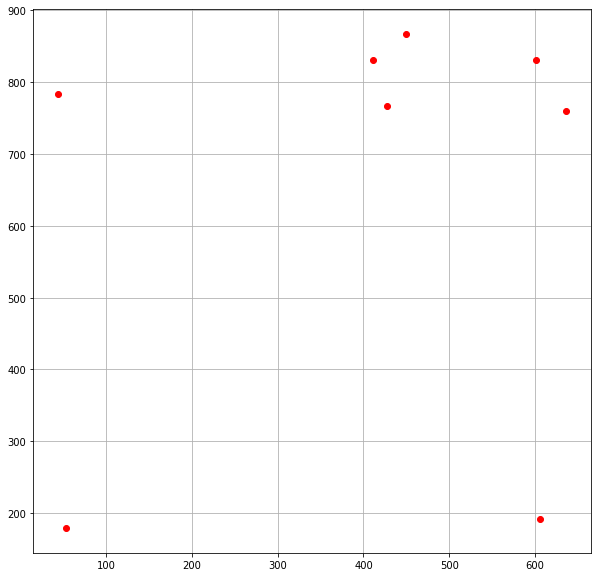

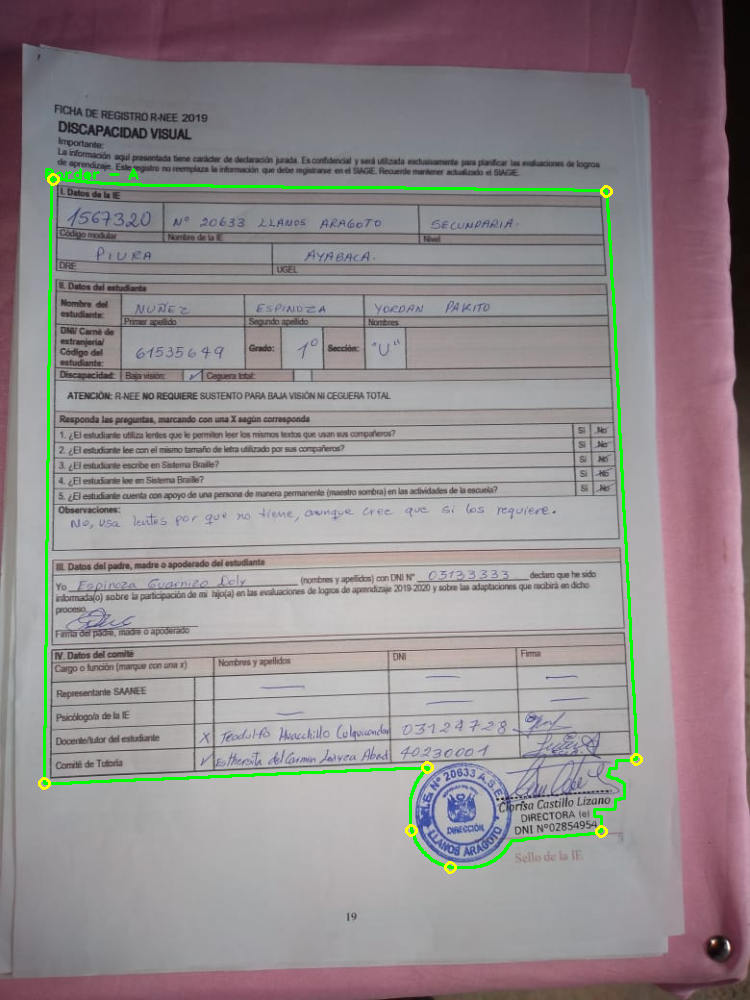

In [40]:
tag = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]
i = 0

#Bucle para recorrer todos los bordes cerrados encontrados
for c in cnts:
  #Obtener el area de cada borde
  area = cv2.contourArea(c)
  #print("Area: " , area)
  #Filtro para no tomar en cuenta los bordes de area pequeña
  if area > 150000:
    #print (c)
    print("Area: " , area)
    epsilon = 0.01 * cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, epsilon, True)

    print('Borde: ' + tag[i] , '/ Angulos: ' + str(len(approx)))

    x,y,w,h = cv2.boundingRect(approx)
    print(x,y,w,h)

    cv2.putText(img_proc, 'Border - ' + tag[i], (x,y), 1,1, (0,255, 0),2)
    cv2.drawContours(img_proc, [c] , 0 ,  (0,255,0),2)
    
    #nuevoContorno = cv2.convexHull(c)
    #cv2.drawContours(img_proc, [nuevoContorno] , 0 ,  (0,255,0),2)

    print(approx)
    
    plt.figure(figsize = (10,10))

    for l in approx:
      plt.plot( l[0][0] , l[0][1], marker="o", color="red")
      i, j = int(l[0][0]) , int(l[0][1])
      cv2.circle(img_proc,(i,j),5,(0,255,255),2)

    plt.grid()
    plt.show()

    cv2_imshow(img_proc)
    i+=1 


##Perspectiva##
Una vez detectados los puntos del area de interes, ubicamos los puntos de los vertices para posicionar correctamente su perspectiva

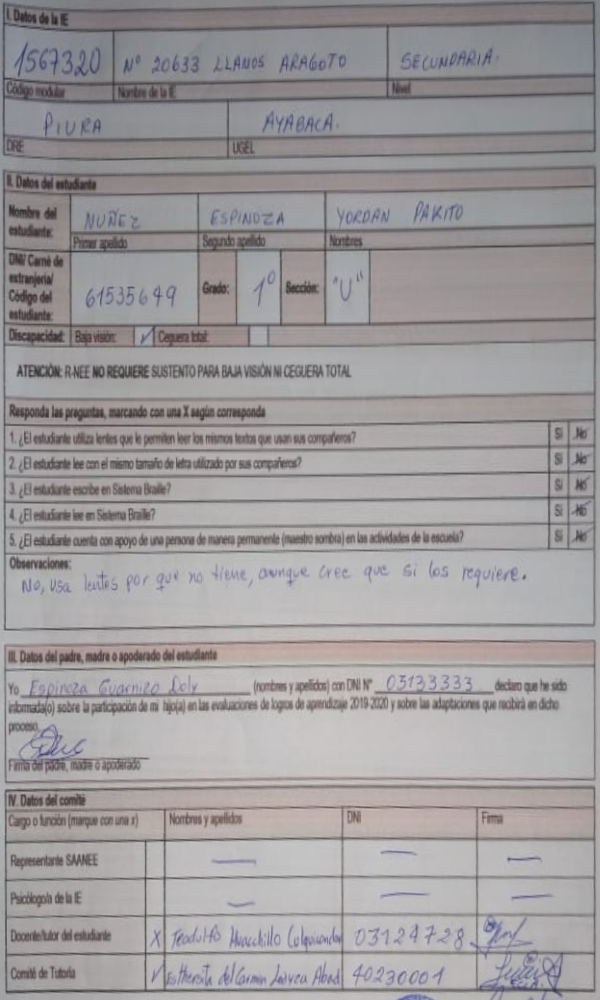

In [70]:
#image = cv2.imread(dir + 'i_perspective.jpeg')
#cv2.circle(image, (84,140),7,(255,0,0),2)
#cv2.circle(image, (630,50),7,(0,255,0),2)
#cv2.circle(image, (0,970),7,(0,0,255),2)
#cv2.circle(image, (700,1020),7,(255,255,0),2)

pts1 = np.float32([
                    [54,179+4],
                    [606,191+4],
                    [44,783],
                    [636,759]
                    ])

pts2 = np.float32([
                    [0,0],
                    [600,0],
                    [0,1000],
                    [600,1000]
                    ])
M = cv2.getPerspectiveTransform(pts1, pts2)
image_destino = cv2.warpPerspective(image, M, (600,1000))
#cv2_imshow(image)
cv2_imshow(image_destino)
cv2.waitKey(0)
cv2.destroyAllWindows()